In [1]:
import os    
#os.environ['THEANO_FLAGS'] = "device=gpu1"  
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32,lib.cnmem=1"
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"
import theano
import numpy as np
from keras.layers import Input, Dense, convolutional,Reshape, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import Model
from keras.optimizers import *

%matplotlib inline






Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce 920M (CNMeM is disabled, cuDNN not available)
Using Theano backend.


In [109]:
# this is our input placeholder
input_img = Input(shape=(3,32,32))

x = convolutional.Convolution2D(32, 5, 5, activation='relu', border_mode='same')(input_img)##32, 32, 32
x = convolutional.MaxPooling2D((2, 2), border_mode='same')(x)##32, 16, 16

x = convolutional.Convolution2D(64, 3, 3, activation='relu', border_mode='same')(x) ##64, 16, 16
x = convolutional.MaxPooling2D((2, 2), border_mode='same')(x) ##64, 8, 8
x = Flatten()(x) ##4096
encoded = Dense(40, activation='relu')(x)

#x = convolutional.Convolution2D(128, 3, 3, activation='relu', border_mode='same')(x)
#encoded = convolutional.MaxPooling2D((2, 2), border_mode='same')(x)

#x = convolutional.UpSampling2D((2, 2))(encoded)
#x = convolutional.Convolution2D(20, 5, 5, activation='relu', border_mode='same')(x)
#x = convolutional.Convolution2D(128, 3, 3, activation='relu', border_mode='same')(encoded)
#x = convolutional.UpSampling2D((2, 2))(x)
x= Dense (4096, activation = 'relu')(encoded)
x = Reshape((64,8,8))(x) ##64 ,8, 8
x = convolutional.Convolution2D(64, 3, 3, activation='relu', border_mode='same')(x) ##64, 8, 8
x = convolutional.UpSampling2D((2, 2))(x) ##64, 16, 16
x = convolutional.Convolution2D(32, 5, 5, activation='relu',border_mode='same')(x) ##32, 16, 16
x = convolutional.UpSampling2D((2, 2))(x) ##32, 32, 32
x = convolutional.Convolution2D(3, 5, 5, activation='sigmoid', border_mode='same')(x) ##3, 32, 32
x = Flatten()(x) ##3072
#x = Dense(3072, activation='linear')(x)
decoded = Reshape((3,32,32))(x) ##3, 32, 32
#decoded = convolutional.Convolution2D(3, 5, 5, activation='sigmoid', border_mode='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='Adam', loss='mean_squared_error',metrics=['accuracy'])

In [110]:
autoencoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_13 (InputLayer)            (None, 3, 32, 32)     0                                            
____________________________________________________________________________________________________
convolution2d_71 (Convolution2D) (None, 32, 32, 32)    2432        input_13[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_25 (MaxPooling2D)   (None, 32, 16, 16)    0           convolution2d_71[0][0]           
____________________________________________________________________________________________________
convolution2d_72 (Convolution2D) (None, 64, 16, 16)    18496       maxpooling2d_25[0][0]            
___________________________________________________________________________________________

In [4]:
X_train=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/X_train.npy')
X_test=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/X_test.npy')
y_train=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/y_train.npy')
y_test=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/y_test.npy')

In [87]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [88]:
x_train = X_train.astype('float32') / 255.
x_test = X_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(50000, 3072)
(10000, 3072)


In [89]:
x_train = x_train.reshape((len(x_train),3,32,32))
x_test = x_test.reshape((len(x_test),3,32,32))
print (x_train.shape)
print (x_test.shape)

(50000, 3, 32, 32)
(10000, 3, 32, 32)


In [111]:
# this model maps an input to its encoded representation
#encoding_dim=40
#encoded = convolutional.Convolution2D(3, 5, 5, activation='relu', border_mode='same')(encoded)
#encoded = Flatten()(encoded)
#encoded = Dense(encoding_dim, activation='sigmoid')(encoded)
#encoded = convolutional.Convolution2D(3, 5, 5, activation='relu', border_mode='same')(encoded)

encoder = Model(input_img, encoded)

In [112]:
print (encoder.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_13 (InputLayer)            (None, 3, 32, 32)     0                                            
____________________________________________________________________________________________________
convolution2d_71 (Convolution2D) (None, 32, 32, 32)    2432        input_13[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_25 (MaxPooling2D)   (None, 32, 16, 16)    0           convolution2d_71[0][0]           
____________________________________________________________________________________________________
convolution2d_72 (Convolution2D) (None, 64, 16, 16)    18496       maxpooling2d_25[0][0]            
___________________________________________________________________________________________

In [96]:
nb_epoch=100
batch_size=256
random_state =5439

In [97]:
kfold_weights_path = os.path.join('weights_kfold_' +  'CIFAR10-Conv-AutoEncoder' +
                                  '_epoch_'+str(nb_epoch)+
                                  '_batch_'+str(batch_size)
                                  +'.h5')
print(kfold_weights_path)

weights_kfold_CIFAR10-Conv-AutoEncoder_epoch_100_batch_256.h5


In [114]:
os.path.isfile(kfold_weights_path)

True

In [115]:
# Some transfer learning
if os.path.isfile(kfold_weights_path):
    print ('Loading already stored weights...')
    autoencoder.load_weights(kfold_weights_path)
else:
    print ('Training for the first time...')
    

Loading already stored weights...


In [116]:
callbacks = [
                EarlyStopping(monitor='val_acc', patience=1, verbose=1),
                ModelCheckpoint(kfold_weights_path, monitor='val_acc', save_best_only=True, verbose=1),
            ]
autoencoder.fit(x_train, x_train,
            nb_epoch=nb_epoch,
            batch_size=batch_size,
            shuffle=True,
            validation_data=(x_test, x_test),
            callbacks=callbacks
            )

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 366s - loss: 0.0276 - acc: 0.0846 - val_loss: 0.0209 - val_acc: 0.0936
Epoch 2/100
50000/50000 [==============================] - 368s - loss: 0.0204 - acc: 0.0963 - val_loss: 0.0197 - val_acc: 0.0977
Epoch 3/100
50000/50000 [==============================] - 353s - loss: 0.0192 - acc: 0.1002 - val_loss: 0.0185 - val_acc: 0.1026
Epoch 4/100
50000/50000 [==============================] - 359s - loss: 0.0178 - acc: 0.1056 - val_loss: 0.0175 - val_acc: 0.1071
Epoch 5/100
50000/50000 [==============================] - 354s - loss: 0.0162 - acc: 0.1161 - val_loss: 0.0161 - val_acc: 0.1163
Epoch 6/100
50000/50000 [==============================] - 369s - loss: 0.0149 - acc: 0.1232 - val_loss: 0.0146 - val_acc: 0.1219
Epoch 7/100
50000/50000 [==============================] - 371s - loss: 0.0142 - acc: 0.1270 - val_loss: 0.0141 - val_acc: 0.1295
Epoch 8/100
50000/50000 [===============

In [99]:
autoencoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_12 (InputLayer)            (None, 3, 32, 32)     0                                            
____________________________________________________________________________________________________
convolution2d_66 (Convolution2D) (None, 32, 32, 32)    2432        input_12[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_23 (MaxPooling2D)   (None, 32, 16, 16)    0           convolution2d_66[0][0]           
____________________________________________________________________________________________________
convolution2d_67 (Convolution2D) (None, 64, 16, 16)    18496       maxpooling2d_23[0][0]            
___________________________________________________________________________________________

In [117]:
reconstructed_test_imgs = autoencoder.predict(x_test)


In [118]:
reconstructed_test_imgs.shape

(10000, 3, 32, 32)

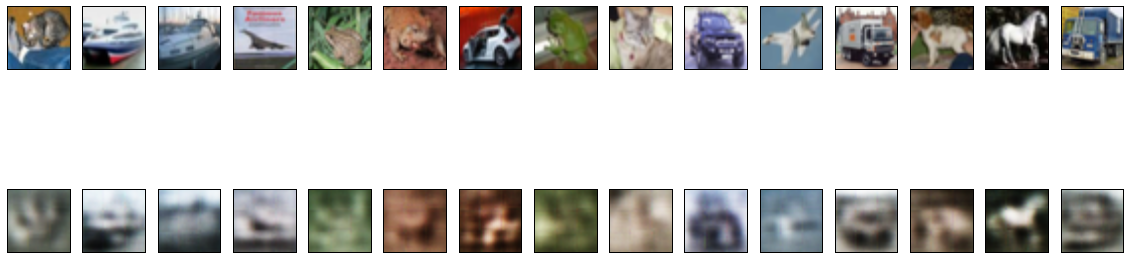

In [119]:
import matplotlib.pyplot as plt

n = 15  # how many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoded
    #ax = plt.subplot(2, n, i + 1 + n)
    #plt.imshow(encoded_imgs[i].reshape(6, 6))
    #plt.gray()
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
   
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_test_imgs[i].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [120]:
print (encoder.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_13 (InputLayer)            (None, 3, 32, 32)     0                                            
____________________________________________________________________________________________________
convolution2d_71 (Convolution2D) (None, 32, 32, 32)    2432        input_13[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_25 (MaxPooling2D)   (None, 32, 16, 16)    0           convolution2d_71[0][0]           
____________________________________________________________________________________________________
convolution2d_72 (Convolution2D) (None, 64, 16, 16)    18496       maxpooling2d_25[0][0]            
___________________________________________________________________________________________

In [121]:
encoded_train_imgs = encoder.predict(x_train)
print (encoded_train_imgs.size)
print (encoded_train_imgs.shape)
print (encoded_train_imgs.nbytes)

2000000
(50000, 40)
16000000


In [122]:
encoded_test_imgs = encoder.predict(x_test)
print (encoded_test_imgs.size)
print (encoded_test_imgs.shape)
print (encoded_test_imgs.nbytes)

400000
(10000, 40)
3200000


In [123]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=4)
clf = clf.fit(encoded_train_imgs, y_train)

In [124]:
y_pred = clf.predict(encoded_test_imgs)


In [125]:
num=len(encoded_test_imgs)
r=0
w=0
for i in range(num):
        #print ('y_pred ',y_pred[i])
        #print ('labels ',labels[i])
        #without the use of all() returns error truth value of an array with more than one element is ambiguous
        #if y_pred[i].all() == labels[i].all():
        if np.array_equal(y_pred[i],y_test[i]):
            r+=1
        else:
            w+=1
print ("tested ",  num, "digits")
print ("correct: ", r, "wrong: ", w, "error rate: ", float(w)*100/(r+w), "%")
print ("got correctly ", float(r)*100/(r+w), "%")


tested  10000 digits
correct:  4045 wrong:  5955 error rate:  59.55 %
got correctly  40.45 %


In [30]:
y_pred

array([2, 8, 8, ..., 5, 2, 2])